In [ ]:
# Perform necessary imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline

# Imports related to classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

# Imports related to confusion matrix
from sklearn.tree import export_graphviz
import pydotplus as pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  

# Support functions import
from support_functions import calculate_accuracy, plot_confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Load csv data into numpy array, skip header row and specify data types.
# note: when I used 'S10' for Class, I got a 'b' in front of each Class, i.e. b'Active' - using 'U10' avoided this.
data = np.genfromtxt("emp_turnover.csv", delimiter=',', skip_header=1,
            dtype={'names': ('Tenure', 'Age', 'Category', 'Gender', 'Department', 'Dept_Ratio', 'Amount', 'Class'),
            'formats': ('i4', 'i4', 'i4', 'i4', 'i4', 'f8', 'f8', 'U10')})

In [ ]:
# View the shape and first five rows of array to get a better feel for the data.
print (data.shape)
data[:5]

(1056,)


array([(1958, 32, 0, 0, 13, 0.006, 39.3733, 'Non-active'),
       (3894, 61, 1, 1, 28, 0.046, 23.0003, 'Non-active'),
       (1672, 22, 2, 0, 17, 0.03 , 21.3228, 'Non-active'),
       (1116, 30, 2, 1, 27, 0.012, 21.3228, 'Non-active'),
       (1795, 24, 2, 0, 21, 0.014, 28.339 , 'Non-active')],
      dtype=[('Tenure', '<i4'), ('Age', '<i4'), ('Category', '<i4'), ('Gender', '<i4'), ('Department', '<i4'), ('Dept_Ratio', '<f8'), ('Amount', '<f8'), ('Class', '<U10')])

   Tenure  Age  Category  Gender  Department  Dept_Ratio   Amount       Class
0    1958   32         0       0          13       0.006  39.3733  Non-active
1    3894   61         1       1          28       0.046  23.0003  Non-active
2    1672   22         2       0          17       0.030  21.3228  Non-active
3    1116   30         2       1          27       0.012  21.3228  Non-active
4    1795   24         2       0          21       0.014  28.3390  Non-active


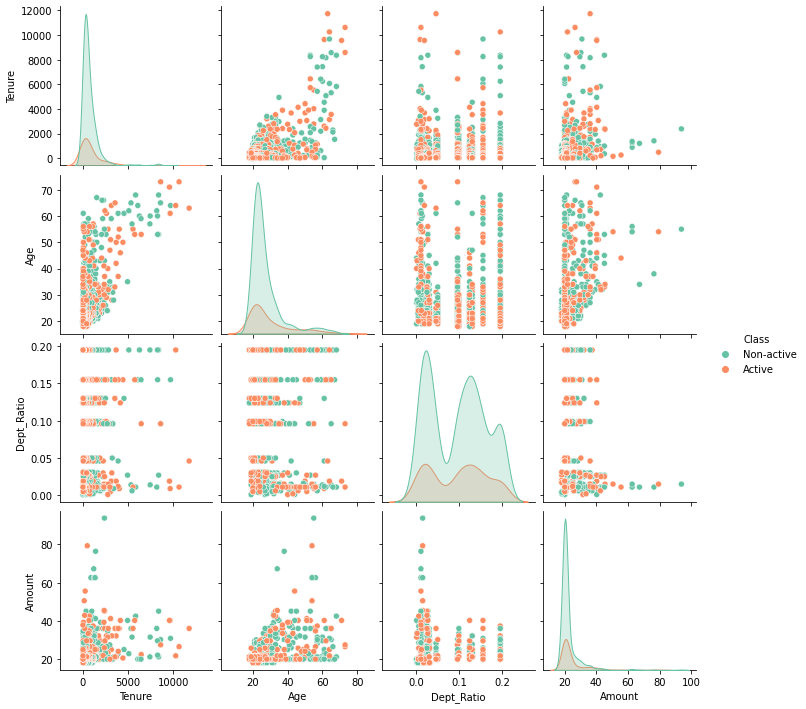

In [ ]:
# Generate a dataframe and pair plot to quickly see what the original numberic fields look like.
df = pd.read_csv('emp_turnover.csv')
# Review first five rows of the dataframe
print (df.head())
# Generate pair plot
sns.pairplot(df.dropna(), vars=['Tenure', 'Age', 'Dept_Ratio', 'Amount'], hue='Class', palette="Set2")

嘗試使用基本方法來分割訓練數據的決策樹分類器，最初是作為一個分數。

In [ ]:
# Set the fraction of data which should be in the training set
fraction_training = 0.70

# Function to split training & testing data via the above fraction
def splitdata_train_test(data, fraction_training):
    # shuffle the numpy array
    np.random.seed(0)
    np.random.shuffle(data)
    split = int(len(data)*fraction_training)
    return data[:split], data[split:]

# Function to generate features and targets from data array.
def generate_features_targets(data):
    # assign the last column 'Class' to targets
    targets = data['Class']

    # 在這裡針對數據中認為最有關係的幾項, 抓出來當作特徵
    features = np.empty(shape=(len(data), 4))
    features[:, 0] = data['Tenure']
    features[:, 1] = data['Age'] 
    features[:, 2] = data['Dept_Ratio'] # feature calculated in csv file via Excel
    features[:, 3] = data['Amount']
        
    return features, targets

# Function to split the data and train a decision tree classifier
def dtc_predict_actual(data):
    # split the data into training and testing sets using a training fraction of 0.7
    train, test = splitdata_train_test(data, fraction_training)

    # generate the feature and targets for the training and test sets
    # i.e. train_features, train_targets, test_features, test_targets
    train_features, train_targets = generate_features_targets(train)
    test_features, test_targets = generate_features_targets(test)

    # instantiate a decision tree classifier
    dtc = DecisionTreeClassifier()

    # train the classifier with the train_features and train_targets
    dtc.fit(train_features, train_targets)

    # get predictions for the test_features
    predictions = dtc.predict(test_features)

    # return the predictions and the test_targets
    return predictions, test_targets


# Call the dtc_predict_actual function and pass data
predicted_class, actual_class = dtc_predict_actual(data)


# calculate the model score using our support function
model_score = calculate_accuracy(predicted_class, actual_class)
print("Our accuracy score:", model_score)

# Print some initial results
print("Some initial results...\n   predicted,  actual")
for i in range(10):
    print("{}. {}, {}".format(i, predicted_class[i], actual_class[i]))

Our accuracy score: 0.7192429022082019
Some initial results...
   predicted,  actual
0. Non-active, Non-active
1. Non-active, Non-active
2. Active, Non-active
3. Active, Active
4. Active, Non-active
5. Active, Non-active
6. Non-active, Non-active
7. Non-active, Non-active
8. Non-active, Non-active
9. Non-active, Non-active


考慮到實際上並沒有大量高質量的特徵/變量可供選擇，決策樹做了一個合理的工作。

In [ ]:
# Use ExtraTreesClassifier to determine feature importance, so it can be compared to the decision tree structure
X, Y = generate_features_targets(data)

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[0.50752959 0.21670349 0.14185128 0.13391563]


特徵重要性順序從大到小； Tenure、Age，然後是 Dept_Ratio 或 Amount，它們的重要性相似。

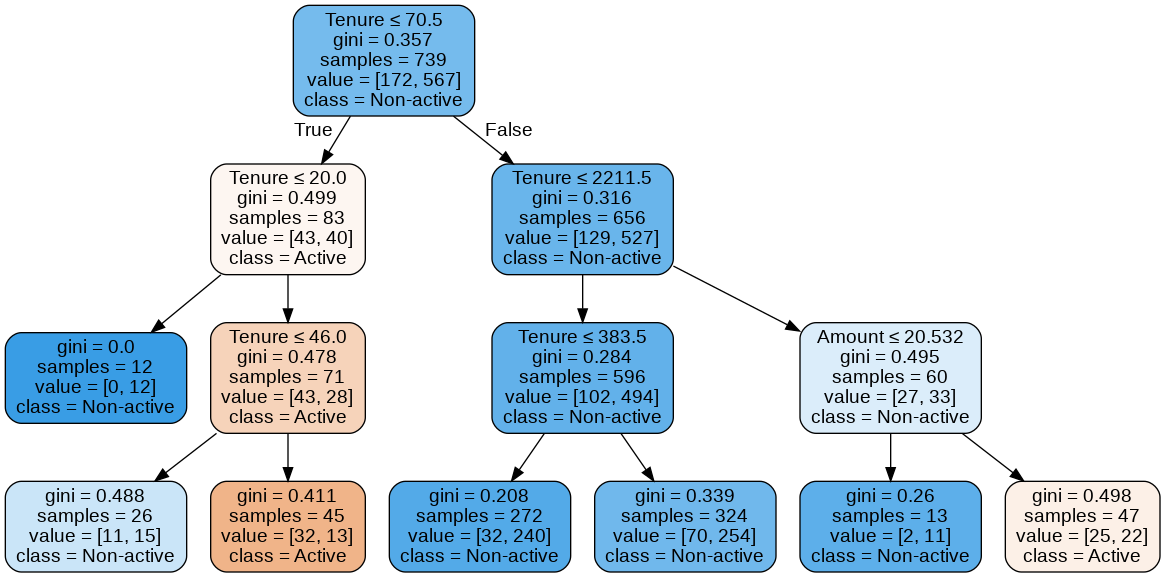

In [ ]:
# split the data into training and testing sets as per above code cell method
train, test = splitdata_train_test(data, fraction_training)

# generate the feature and targets for the training and test sets
train_features, train_targets = generate_features_targets(train)
test_features, test_targets = generate_features_targets(test)

# Create a new decision tree classifier with limited depth and fit
dtree = DecisionTreeClassifier(max_depth=3) # If the Decision Tree was based on maximum depth set to None (default),
                       # then nodes are expanded until all leaves are pure which would be too complex to review,
                       # or even read, without zooming in on only a part of the tree.
dtree.fit(train_features, train_targets)

# Use graphviz, pydotplus to view the decision tree
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data, filled=True, rounded=True, special_characters=True, 
               feature_names=['Tenure', 'Age', 'Dept_Ratio', 'Amount'], class_names=list(set(train_targets)))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
#graph.write_jpg("decision_tree_sample.jpg")

使用決策樹的最大優勢之一是我們可以根據它們在樹中的深度位置輕鬆查看哪些特徵或變量有助於分類及其相對重要性。 樹根（頂部）的特徵被認為對決策更重要。
Tenure 一直位居榜首，表明它是最有用的功能。 這與上面的 Extra Trees 模型一致並且很直觀，因為 Tenure 特徵在之前的散點圖中顯示了更清晰的關係。

稍早都是手動方式決定, 現在驗證資訊, 看看自動由機器做可以做成如何 ==> 驗證我們的假設

Our accuracy score: 0.8068181818181818
Confusion matrix, without normalization
[[109 142]
 [ 62 743]]


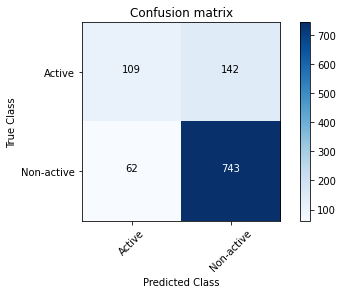

In [ ]:
from sklearn import metrics

# Call function to generate features and targets
features, targets = generate_features_targets(data)

# get predictions using 10-fold cross validation with cross_val_predict
dtc = DecisionTreeClassifier(max_depth=4, criterion='entropy')
predicted = cross_val_predict(dtc, features, targets, cv=10)

# calculate the model score using support function
model_score = calculate_accuracy(predicted, targets)
print("Our accuracy score:", model_score)

# calculate the models confusion matrix using sklearns confusion_matrix function
class_labels = list(set(predicted))
model_cm = confusion_matrix(y_true=targets, y_pred=predicted, labels=class_labels)

# Plot the confusion matrix using the provided functions.

plt.figure()
plot_confusion_matrix(model_cm, classes=class_labels)
plt.savefig('dt_confusion_matrix.png')
plt.show()

使用隨機森林分類器來預測類別。

Accuracy score: 0.8134469696969697
Confusion matrix, without normalization
[[120 131]
 [ 66 739]]


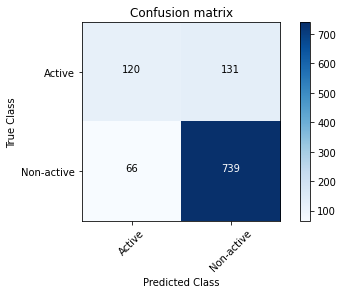

In [ ]:
# Get predictions from a random forest classifier

def rf_predict_actual(data, n_estimators):
    # generate the features and targets
    features, targets = generate_features_targets(data)

    # instantiate a random forest classifier
    rfc = RandomForestClassifier(n_estimators=n_estimators)
  
    # get predictions using 10-fold cross validation with cross_val_predict
    predicted = cross_val_predict(rfc, features, targets, cv=10)

    # return the predictions and their actual classes
    return predicted, targets

    
# get the predicted and actual classes
number_estimators = 50    # Number of trees
predicted, actual = rf_predict_actual(data, number_estimators)

# calculate the model score using the calling the previously created function
accuracy = calculate_accuracy(predicted, actual)
print("Accuracy score:", accuracy)

# calculate the models confusion matrix using sklearns confusion_matrix function
class_labels = list(set(actual))
model_cm = confusion_matrix(y_true=actual, y_pred=predicted, labels=class_labels)

# plot the confusion matrix using the provided functions.
plt.figure()
plot_confusion_matrix(model_cm, classes=class_labels)
plt.savefig('rf_confusion_matrix.png')
plt.show()

In [ ]:
# Print some initial results, including selected features
print("Some initial results...\n   predicted,  actual, Tenure, Age, Dept_Ratio, Amount")
for i in range(10):
    print("{}. {}, {}, {}, {}, {}, {}".format(i, predicted[i], actual[i], features[i, 0], features[i, 1], features[i, 2], features[i, 3]))

Some initial results...
   predicted,  actual, Tenure, Age, Dept_Ratio, Amount
0. Non-active, Non-active, 363.0, 22.0, 0.017, 18.29
1. Non-active, Non-active, 1083.0, 26.0, 0.155, 20.1415
2. Non-active, Non-active, 353.0, 23.0, 0.02, 18.29
3. Non-active, Non-active, 404.0, 23.0, 0.124, 20.1415
4. Non-active, Active, 219.0, 29.0, 0.096, 20.1415
5. Non-active, Active, 1146.0, 26.0, 0.096, 20.1415
6. Active, Non-active, 425.0, 18.0, 0.195, 20.1415
7. Non-active, Non-active, 41.0, 25.0, 0.096, 20.1415
8. Non-active, Non-active, 32.0, 30.0, 0.027, 34.8607
9. Non-active, Non-active, 729.0, 23.0, 0.027, 18.29


根據上述算法，這些員工在未來應該有更高的辭職可能性。 考慮到這一點，讓我們快速查看並在必要時導出到 csv 文件。

In [ ]:
# Create a list, convert to a dataframe and review.

# create empty list
errors = []

# loop through the output of the rf_predict_actual function for the errors of interest
for i in range(len(predicted)):
    if (predicted[i] == 'Non-active') & (actual[i] == 'Active'):
        errors.append([predicted[i], actual[i], features[i, 0], features[i, 1], features[i, 2], features[i, 3]])
                
# create a dataframe and set column names
error_df = pd.DataFrame(errors, columns=('predicted', 'actual', 'tenure', 'age', 'dept_ratio', 'amount'))

# take a look
print (error_df.head())
print (error_df.describe())   # count can be reconciled with the top-right quadrant of the confusion matrix

    predicted  actual  tenure   age  dept_ratio   amount
0  Non-active  Active   219.0  29.0       0.096  20.1415
1  Non-active  Active  1146.0  26.0       0.096  20.1415
2  Non-active  Active  1135.0  25.0       0.155  23.4324
3  Non-active  Active  1835.0  23.0       0.124  21.3228
4  Non-active  Active   243.0  22.0       0.124  20.1415
             tenure         age  dept_ratio      amount
count    131.000000  131.000000  131.000000  131.000000
mean    1212.038168   31.122137    0.096214   24.756250
std     1713.782678   12.023709    0.061703    8.154546
min       16.000000   18.000000    0.001000   18.290000
25%      244.000000   22.000000    0.027000   20.141500
50%      623.000000   27.000000    0.099000   21.322800
75%     1428.000000   36.500000    0.142500   25.870900
max    10247.000000   73.000000    0.195000   79.326900


In [ ]:
# Export errors to csv file for cataloguing if necessary.
from datetime import datetime

# create timestamp string
date_stamp = datetime.now().strftime('%d.%m.%Y')
# convert string to date time object and add column to error_df
error_df['date'] = pd.to_datetime(date_stamp)
# export to csv
error_df.to_csv('errors_' + date_stamp + '.csv', sep=',', index=False)